# 📈 Stock Market Prediction using LSTM (Machine Learning)
**Descrption:** This program uses an artificial recurrent neural network called Long Short Term Memory(LSTM) to predict the closing stock price of a corporation, using past 60 days stock price.

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
// will prevent jupyter notebook to enter into scroll mode when the output is long

<IPython.core.display.Javascript object>

In [2]:
# Import necessary libraries
import pandas_datareader as web
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,LSTM
import warnings
from sklearn.metrics import r2_score
from datetime import date
from datetime import timedelta

In [3]:
# from tensorflow import random as tf_random
# tf_random.set_seed(2)

In [4]:
# setting up graph style
plt.style.use("fivethirtyeight")

In [5]:
stock=input("Enter stock name:").upper()
code=input("Enter stock code:").upper()
if code=="":
    stock_code=stock
else:
    stock_code=stock+"."+code
stock_code=stock_code
print(f"Collecting the stock data of {stock_code}")

Enter stock name:wipro
Enter stock code:ns


## 1. Data Collection and visualization

In [6]:
# Fetching data from the internet
df= web.DataReader(stock_code, data_source="yahoo", start='2012-01-01', end='2022-04-02')

In [7]:
# printing the stock DataFrame in tabular format
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-02,150.712540,148.275040,149.625031,149.625031,1708458.0,134.396896
2012-01-03,156.712540,150.506287,150.881287,156.187546,5764897.0,140.291504
2012-01-04,159.375046,155.756287,157.012543,156.843796,5075777.0,140.880966
2012-01-05,158.587540,154.200043,155.887543,155.606293,3031457.0,139.769409
2012-01-06,154.856293,151.162537,154.856293,152.156281,3327636.0,136.670486
...,...,...,...,...,...,...
2022-03-28,609.000000,597.099976,608.000000,600.200012,5738405.0,595.244629
2022-03-29,605.349976,599.150024,603.000000,602.500000,4701003.0,597.525635
2022-03-30,609.299988,599.500000,605.099976,600.799988,7744382.0,595.839600


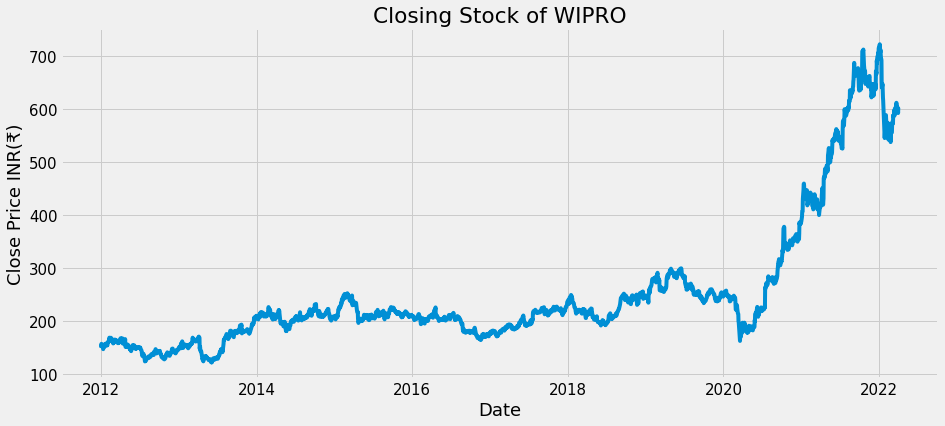

In [8]:
# Plotting and visualizing the Closing price of stock in graphical format
plt.rcParams.update({'font.size': 15})
# plt.figure(figsize=(14,6))
fig,ax=plt.subplots(figsize=(14,6))
ax.plot(df["Close"])
plt.title("Closing Stock of "+stock)
plt.xlabel("Date")
plt.ylabel("Close Price INR(₹)");
fig.savefig("./Images_exported/Closing Stock.png",bbox_inches = 'tight')

## 2. Pre-Processing Data
### 2.1 Feature Engineering

In [9]:
np.random.seed(42)
# Create a dataframe only with closing columns
data=df.filter(["Close"])
# Convert the data into a numpy array
dataset=data.values
# get the number of row to train the model on
training_data_len=math.ceil(len(dataset)*0.8)
training_data_len

2022

In [10]:
np.random.seed(42)
# scale the data
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data= scaler.fit_transform(dataset)
scaled_data

array([[0.04630875],
       [0.05725278],
       [0.05834718],
       ...,
       [0.79871379],
       [0.7838717 ],
       [0.80038145]])

### 2.2 Creating Training Dataset

In [11]:
np.random.seed(42)
# Creating Scaled Training dataset
train_data= scaled_data[0:training_data_len,:]
# Split the data into x_train and y_train for training dataset
x_train=[]
y_train=[]

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.04630875, 0.05725278, 0.05834718, 0.05628345, 0.05053001,
       0.04765332, 0.0491542 , 0.04774711, 0.04158722, 0.0475595 ,
       0.05159316, 0.05640852, 0.04949816, 0.04952943, 0.05553298,
       0.056815  , 0.05884745, 0.05916014, 0.05819083, 0.05306277,
       0.0556268 , 0.05434478, 0.06322505, 0.06410059, 0.0638817 ,
       0.0644758 , 0.06857198, 0.07545107, 0.07779621, 0.06982273,
       0.06888467, 0.06951004, 0.0715425 , 0.07748352, 0.07426287,
       0.07370002, 0.07285579, 0.07063571, 0.06244334, 0.05959792,
       0.0671649 , 0.06247461, 0.06506992, 0.06653953, 0.06700855,
       0.07191773, 0.0670711 , 0.07054192, 0.06628939, 0.06322505,
       0.06410059, 0.06478848, 0.06444455, 0.06544513, 0.06419438,
       0.06025454, 0.06272478, 0.06138021, 0.06469469, 0.06560147])]
[0.0699477948776906]



In [12]:
np.random.seed(42)
x_train,y_train=np.array(x_train),np.array(y_train)
x_train.shape,y_train.shape

((1962, 60), (1962,))

### 2.3 Reshaping Data
**Note:** An LSTM Algo expect the data to be in 3D format- `[(no. of sample), (no. of time step), (no. of features)]`

In [13]:
np.random.seed(42)
# Reshape the data
np.random.seed(42)
x_train=np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape 

(1962, 60, 1)

## 3. Modelling
### 3.1 Setting up LSTM model

In [14]:
np.random.seed(42)
# Build the LSTM Model
np.random.seed(42)
model=Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [15]:
np.random.seed(42)
# compile the model
np.random.seed(42)
model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
%%time
np.random.seed(42)
# Train the model
model.fit(x_train,y_train,batch_size=1,epochs=1);

1962/1962 [==============================] - 41s 20ms/step - loss: 2.4793e-04
Wall time: 41.2 s


### 3.2 Setting up test data 

In [17]:
np.random.seed(42)
# create the test dataset
# create a new array containing scaled values from index= training data has ended, to the length of the collected data
test_data= scaled_data[training_data_len-60:,:]
# create the dataset x_test, y_test
x_test=[]
y_test=dataset[training_data_len:,:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [18]:
# convert the data into numpy array
x_test,y_test=np.array(x_test),np.array(y_test)

In [19]:
# Reshape the data
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [20]:
# Get the model predicted price value
predictions= model.predict(x_test)
predictions= scaler.inverse_transform(predictions)

## 4. Model Evaluation
### 4.1 Calculating Loss/Error using Root Mean Squared Error (RMSE)

In [21]:
rmse=round(np.sqrt(np.mean(predictions-y_test)**2),4)
rmse

20.7685

### 4.2 Calculating Accuracy using R-Square metrics 

In [22]:
# Model Accuracy
r2=round(r2_score(y_test,predictions),4)
print(f"Model Accuracy accroding to R square is {r2*100}%")

Model Accuracy accroding to R square is 97.19%


### 4.3 Visualizing model performance

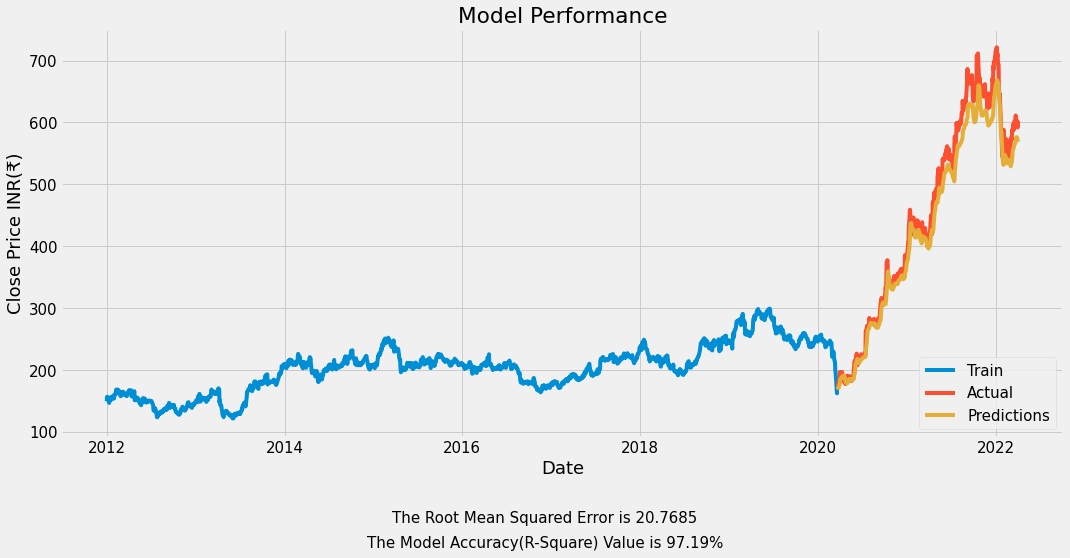

In [23]:
warnings.filterwarnings("ignore")
# plot the data
train=data[:training_data_len]
valid=data[training_data_len:]
valid["predictions"]=predictions

# Visualizing the data
fig,ax=plt.subplots(figsize=(16,7))
plt.title('Model Performance')
plt.xlabel("Date")
plt.ylabel("Close Price INR(₹)")
ax.plot(train["Close"])
ax.plot(valid[["Close", "predictions"]])
plt.legend(["Train","Actual","Predictions"], loc="lower right");
# plt.text(1,1,"kncjbdasdnbvsvlsn dvlns dv")
rmse1="The Root Mean Squared Error is "+str(rmse)
r21="The Model Accuracy(R-Square) Value is "+str(r2*100)+"%"
fig.text(0.5,-0.1,rmse1,horizontalalignment='center')
fig.text(0.5,-0.15,r21,horizontalalignment='center')
fig.savefig("./Images_exported/Model_performance.png",bbox_inches = 'tight')

## 5. Model Deployment

In [24]:
# getting todays date
today = date.today()
print("Today's date:", today)

#Get the quote

df_quote=web.DataReader(stock_code, data_source='yahoo', start='2012-01-01', end=today)

#Create a new dataframe

new_df = df_quote.filter(['Close'])

#Get teh last 60 day closing price values and convert the dataframe to an array

last_60_days = new_df[-60:].values

#Scale the data to be values between 0 and 1

last_60_days_scaled = scaler.transform(last_60_days)

#Create an empty list

X_test=[]

#Append teh past 60 days

X_test.append(last_60_days_scaled)

#Convert the X_test data set to a numpy array

X_test = np.array(X_test)

#Reshape the data

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#Get the predicted scaled price

pred_price = model.predict(X_test)

#undo the scaling

pred_price = scaler.inverse_transform(pred_price)

print("Predicted Stock Price is: ₹",pred_price[0][0])

Today's date: 2022-06-12
Predicted Stock Price is: ₹ 454.3594


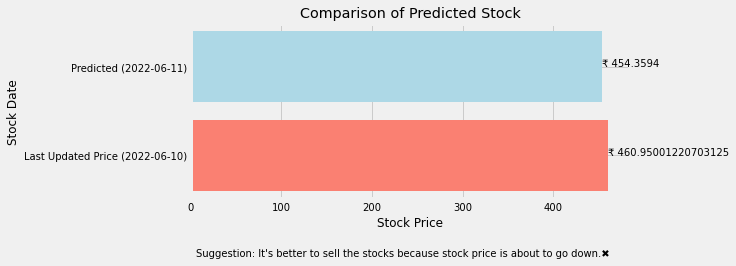

In [25]:

# setting up values
p=pred_price[0][0]
r=df_quote["Close"][-1:].values[0]
a=(df_quote["Close"].index[-1])
ri="Last Updated Price ("+str(df_quote["Close"].index[-1])[0:10]+")"
pi="Predicted ("+str(a+timedelta(days=1))[0:10]+")"
plt.rcParams.update({'font.size': 10})
# creating the dictionary
compare={ri:r, pi:p}
# plotting the dictionary
fig,ax=plt.subplots(figsize=(7,3))
ax.barh(list(compare.keys()),list(compare.values()), color=["salmon","lightblue"])
for index, value in enumerate(compare.values()):
    plt.text(value, index,
             "₹ "+str(value))
ax.set(title="Comparison of Predicted Stock",
      xlabel="Stock Price",
      ylabel="Stock Date");
print()
if r>p:
    fig.text(0.5,-0.2,"Suggestion: It's better to sell the stocks because stock price is about to go down.✖",horizontalalignment='center')
else:
    fig.text(0.5,-0.2,"Suggestion: It's better to invest the stocks because stock price is about to go up.✔",horizontalalignment='center')
fig.savefig("./Images_exported/Comparison_of_Prediction_Stock.png",bbox_inches = 'tight',horizontalalignment='center')